In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dataset/artist.zip -d /content/drive/MyDrive/dataset/artist

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_61.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_62.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_63.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_64.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_65.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_66.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_67.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_68.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_69.jpg  
  inflating: /content/drive/MyDrive/dataset/artist/resized/resized/Henri_Rousseau_7.jpg  
  inflating: /content/drive/MyDrive/data

In [ ]:
!pip install keras-efficientnet-v2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image
import keras_efficientnet_v2

from numpy.random import seed

seed(1)
tf.random.set_seed(1)

import warnings

warnings.filterwarnings('ignore')

artists = pd.read_csv("/content/drive/MyDrive/dataset/artist/artists.csv")

artists = artists.sort_values(by=['paintings'], ascending=False)
# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
# artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
print(artists_top)

class_weights = artists_top['class_weight'].to_dict()

                     name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Dürer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223


In [ ]:
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [ ]:
images_dir = '/content/drive/MyDrive/dataset/artist/images/images/'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values
# We are checking to see if there are any problems
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Not found -->", os.path.join(images_dir, name))


Found --> /content/drive/MyDrive/dataset/artist/images/images/Vincent_van_Gogh
Found --> /content/drive/MyDrive/dataset/artist/images/images/Edgar_Degas
Found --> /content/drive/MyDrive/dataset/artist/images/images/Pablo_Picasso
Found --> /content/drive/MyDrive/dataset/artist/images/images/Pierre-Auguste_Renoir
Found --> /content/drive/MyDrive/dataset/artist/images/images/Albrecht_Dürer
Found --> /content/drive/MyDrive/dataset/artist/images/images/Paul_Gauguin
Found --> /content/drive/MyDrive/dataset/artist/images/images/Francisco_Goya
Found --> /content/drive/MyDrive/dataset/artist/images/images/Rembrandt
Found --> /content/drive/MyDrive/dataset/artist/images/images/Alfred_Sisley
Found --> /content/drive/MyDrive/dataset/artist/images/images/Titian
Found --> /content/drive/MyDrive/dataset/artist/images/images/Marc_Chagall


In [ ]:
inter_op_parallelism_threads = -1
# EfficientNetV2S input shape is 384 by 384
input_shape = (384, 384, 3)

base_model = keras_efficientnet_v2.EfficientNetV2S(pretrained="imagenet",
                                                   classifier_activation='softmax',
                                                   include_preprocessing=True,
                                                   input_shape=input_shape)
base_model.trainable = True


87846816/87846816 [==============================] - 6s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5


In [ ]:
batch_size = 16  # total images / batch size = total augmented data
n_classes = artists_top.shape[0]

datagen = image.ImageDataGenerator(validation_split=0.15,
                                   rescale=1. / 255.,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )

train_generator = datagen.flow_from_directory(directory=images_dir,
                                              class_mode='categorical',
                                              target_size=input_shape[0:2],
                                              batch_size=batch_size,
                                              subset="training",
                                              shuffle=True,
                                              classes=artists_top_name.tolist()
                                              )

valid_generator = datagen.flow_from_directory(directory=images_dir,
                                              class_mode='categorical',
                                              target_size=input_shape[0:2],
                                              batch_size=batch_size,
                                              subset="validation",
                                              shuffle=True,
                                              classes=artists_top_name.tolist()
                                              )

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3660 images belonging to 11 classes.
Found 639 images belonging to 11 classes.
Total number of batches = 228 and 39


In [ ]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.2)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.2)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

optimizer = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
n_epoch = 5

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                              verbose=1, mode='auto')

history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                               epochs=n_epoch,
                               shuffle=True,
                               verbose=1,
                               callbacks=[reduce_lr],
                               use_multiprocessing=True,
                               workers=-1,
                               class_weight=class_weights
                               )

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=1, mode='auto')
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:70]:
    layer.trainable = True

optimizer = Adam(lr=0.00005)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

n_epoch = 5
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                               epochs=n_epoch,
                               shuffle=True,
                               verbose=1,
                               callbacks=[reduce_lr, early_stop],
                               use_multiprocessing=True,
                               workers=16,
                               class_weight=class_weights
                               )

Epoch 1/5
228/228 [==============================] - 3330s 14s/step - loss: 1.8715 - accuracy: 0.3526 - val_loss: 2.3142 - val_accuracy: 0.2612 - lr: 5.0000e-04
Epoch 2/5
228/228 [==============================] - 158s 692ms/step - loss: 1.4049 - accuracy: 0.5875 - val_loss: 1.9093 - val_accuracy: 0.5577 - lr: 5.0000e-04
Epoch 3/5
228/228 [==============================] - 162s 709ms/step - loss: 1.1418 - accuracy: 0.6858 - val_loss: 2.3917 - val_accuracy: 0.2628 - lr: 5.0000e-04
Epoch 4/5
228/228 [==============================] - 162s 709ms/step - loss: 0.9856 - accuracy: 0.7357 - val_loss: 1.6653 - val_accuracy: 0.4599 - lr: 5.0000e-04
Epoch 5/5
228/228 [==============================] - 156s 681ms/step - loss: 0.8113 - accuracy: 0.7821 - val_loss: 1.8002 - val_accuracy: 0.4679 - lr: 5.0000e-04
Epoch 1/5
228/228 [==============================] - 191s 750ms/step - loss: 0.4838 - accuracy: 0.8828 - val_loss: 0.5660 - val_accuracy: 0.8542 - lr: 5.0000e-05
Epoch 2/5
228/228 [==========

In [ ]:
model.save("/content/drive/MyDrive/models/model.h5")

In [ ]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

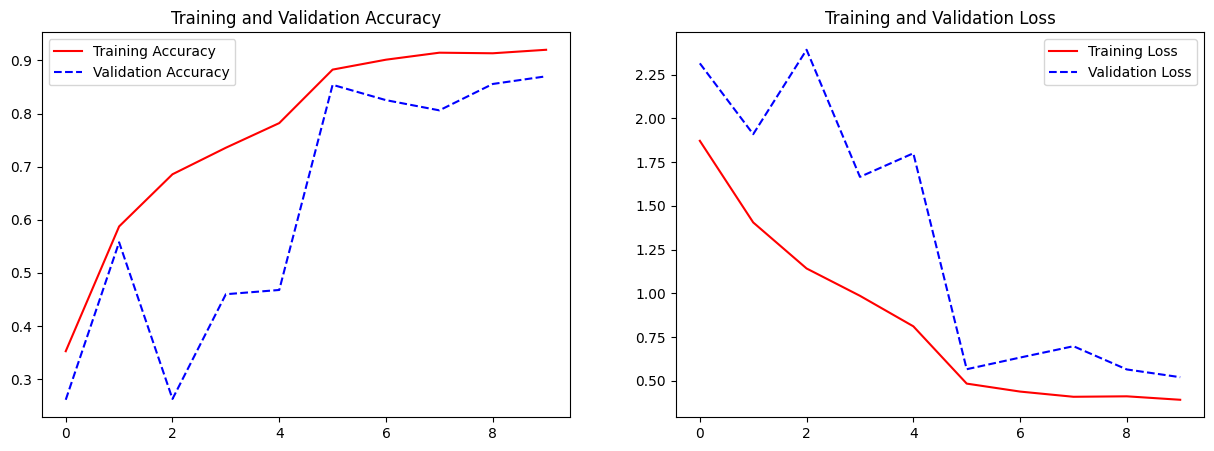

In [ ]:
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)